<a href="https://colab.research.google.com/github/enzoconejero/utnba-iaa-2021-property-price-prediction/blob/master/propierati_regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicción de precios de Propierati con regresión



# Importar librerías y funciones auxiliares

In [21]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import ipywidgets as widgets

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from matplotlib.pyplot import figure

from tensorflow.keras.utils import plot_model

In [22]:
def filter_quantile(df, columna, quantil, tipo='max'):
    if tipo not in ('max', 'min'):
        raise ValueError(f"Parámetro 'extreme' debe ser 'max' o 'min'. Se recibió {tipo}")
    extremo = df[columna].quantile(quantil)
    if tipo == 'max':
        df = df[df[column] <= extremo]
    else:
        df = df[df[column] >= extremo]
    return df


def generar_estadisticas_detalladas(orDF, titulo=""):
  # título
  print("\n", titulo, ": ") 
  # obtiene las estadísticas generales
  estDF = orDF.describe().transpose()
  #  genera y formatea las estadísticas
  if "min" in estDF and "max" in estDF:
    rangoValores = "[ " + estDF["min"].apply('{:.2f}'.format) + " ; " + estDF["max"].apply('{:.2f}'.format) + " ]"    
  else:
    rangoValores = estDF["unique"].fillna(0.0).apply('{:.0f}'.format)
  rangoValores.name = "Rango Valores"
  # para campos no numéricos muestra las cantidades por valor
  for col in orDF.columns:
    if orDF[col].dtypes in ("object", "bool"):
      auxStr = str( orDF[col].value_counts() ).replace("\n", " ; ")
      if (auxStr.index("Name")-3) > 0:
        # saca lo del final porque no sirve
        auxStr = auxStr[:auxStr.index("Name")-3]
      rangoValores[col] = "{ " + auxStr + " }"
  if "mean" in estDF and "std" in estDF:      
    promValores = estDF["mean"].fillna(0.0).apply('{:.3f}'.format) + " ± " + estDF["std"].fillna(0.0).apply('{:.3f}'.format)
  else:
    promValores = estDF["count"].apply('{:.0f}'.format)
  promValores.name = "Promedio ± Desvío"
  # obtiene valores "ceros" y nulos
  zero_val = (orDF == 0.00).astype(int).sum(axis=0)
  zero_val.name = "¿Valores Ceros?"
  mis_val = orDF.isnull().sum()
  mis_val.name = "¿Valores Nulos?"
  # prepara la nueva tabla para mostrar
  nTable = pd.concat([orDF.dtypes, rangoValores, promValores, zero_val, mis_val], axis=1)
  nTable = nTable.rename( columns = {0: 'Tipo Valor',  1: 'Rango Valores', 2: 'Promedio ± Desvío', 3: '¿Valores Ceros?', 4: '¿Valores Nulos?' } )
  # muestra la nueva tabla
  pd.set_option('max_colwidth', None)
  display(nTable.fillna("-"))
  print("Tiene " + str(orDF.shape[1]) + " atributos y " + str(orDF.shape[0]) + " ejemplos.")
  print("\n")
  return 

def plot_box_graph(ndf, titulo):  # genGraph_BoxPlot
  fig = plt.figure(figsize=(15,8)) 
  legValues = []
  colValues = []
  for col in ndf.columns:    
    if ndf[col].dtypes != "object":
      legValues.append( col )
      colValues.append( ndf[col].fillna(0.001) )
  if len(colValues)>0:
    ax = fig.add_axes( [0, 0, 0.8, 0.8] )
    ax.boxplot( colValues )
    ax.set_xticklabels( legValues )
  plt.grid(color='lightgrey', which='major', axis='y', linestyle='solid', linewidth=0.3)
  plt.title(titulo)
  plt.show()

def is_numeric(col):
    return col.dtypes != "object"

def only_numerics(df):
    dfn = df.copy()
    for col in dfn.columns:
        if not is_numeric(dfn[col]):
            dfn.pop(col)
    return dfn

def plot_pca(df, dims=2, classes=np.array([])):
    """PCA: Principal Componenet Analysis
    Reduce dimensiones de un dataframe
    Reduciendo a 2 dimensiones se puede graficar
    """
    df_pca = only_numerics(df)
    pca = PCA(n_components=dims).fit(df_pca)

    df_pca = pd.DataFrame(pca.transform(df_pca), columns=('x', 'y'))
    
    if len(classes) > 0:
        df_pca['class'] = classes
    else:
        df_pca['class'] = np.array([0]*len(df_pca))

    sns.lmplot(x='x', y='y',
            data = df_pca,
            fit_reg = False,
            hue='class'
    )

# Cargar dataset

In [23]:
# Montar volumen de drive
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

try:
    raw_data = raw_data
    display('No es necesario recargar el dataset inicial')
except NameError:
    display('Descargando dataset')
    raw_data = pd.read_csv("https://ia1avanzada.blob.core.windows.net/data-properati/ar_properties.csv", delimiter=',', parse_dates = True)
    display('Dataset descargado')

'No es necesario recargar el dataset inicial'

# Preparar datos

In [24]:
#@title Filtrar datos de interés 
#@markdown - Tipo de propiedad: Departamento, PH, Casa y Oficina
#@markdown - Moneda de venta: USD
#@markdown - Localidad: Capital Federal
#@markdown - Operación: Venta

data = raw_data.copy()
data = data[data.l2 == 'Capital Federal']
data = data.loc[data['property_type'].isin(['Departamento', 'PH', 'Casa', 'Oficina'])]
data = data[data.operation_type == 'Venta']
data = data[data.currency == 'USD']

print(f'Total: {len(data)} propiedades para compra-venta en CABA')

Total: 123946 propiedades para compra-venta en CABA


In [25]:
#@title Normalizar barrio
#@markdown Elegir el nivel de detalle más alto de localidad

# Nivel más detallista de localidad con datos es l4
data['l4'] = data.l4.fillna(0)
data['l4'] = np.where(data['l4'] == 0, data['l3'], data['l4'])
data.rename(columns={'l4': 'neighborhood'}, inplace=True)

print(f'{len(data.neighborhood.unique())} Barrios en {len(data.neighborhood.notnull())} propiedades')

62 Barrios en 123946 propiedades


In [26]:
#@title Borrar columnas innecesarias
#@markdown Aquellos datos que no tienen relevancia en el cálculo del precio
data = data.drop(columns=['ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3', 'l5', 'l6', 'id', 'title', 'description', 'price_period', 'currency', 'operation_type'], axis=1)
data.head()

,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
215,Villa Luro,3.0,NaN,2.0,84.0,74.0,135900.0,Departamento
216,Boca,1.0,NaN,1.0,28.0,26.0,56000.0,Departamento
224,Barracas,2.0,NaN,2.0,82.0,71.0,270000.0,Departamento
225,Belgrano,NaN,NaN,NaN,23.0,23.0,72000.0,Oficina
226,Paternal,1.0,NaN,1.0,25.0,23.0,50400.0,Departamento


In [27]:
#@title Borrar registros con datos incompletos

# Se borran los datos null
cant_inicial = len(data)
data = data.dropna()
# Se borran los registros con -1 habitaciones
data = data[data.bedrooms > 0]
display(f'{len(data)} propiedades filtradas de {cant_inicial}')

'67501 propiedades filtradas de 123946'

In [28]:
#@title Filtrar registros con valores extremos
#@markdown Se buscan los valores extremos de cada columna usando quantiles y se filtran

# Las columnas con valores numéricos son las que pueden tener extremos
quantilizables = ['rooms', 'bedrooms', 'surface_total', 'surface_covered', 'price']

print('Con extremos')
data.describe().transpose()

for column in quantilizables:
    data = filter_quantile(data, column, 0.975)

data = filter_quantile(data, 'price', 0.001, 'min')

print('Sin extremos')
data.describe().transpose()


Con extremos
Sin extremos


,count,mean,std,min,25%,50%,75%,max
rooms,61043.0,2.779057,1.024064,1.0,2.0,3.0,3.0,6.0
bedrooms,61043.0,1.839654,0.856027,1.0,1.0,2.0,2.0,4.0
bathrooms,61043.0,1.401733,0.644724,1.0,1.0,1.0,2.0,10.0
surface_total,61043.0,78.209082,41.429062,10.0,48.0,67.0,96.0,291.0
surface_covered,61043.0,68.351424,33.644598,1.0,43.0,60.0,83.0,200.0
price,61043.0,199084.150599,121281.244191,34300.0,115000.0,164700.0,248000.0,700000.0


In [44]:
#@title Normalizar datos numéricos (OPCIONAL) { run: "auto" }

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

data_norm = data.copy()

if aplica_normalizacion:

    print("5 primeros ejemplos antes de normalizar: ")
    display(data_norm.head())

    # elegir el método de normalización
    scaler = {
        'Standard Scaler': StandardScaler(),
        'MinMax Scaler': MinMaxScaler(),
        'MaxMax Scaler': MaxAbsScaler(),
        'Robust Scaler': RobustScaler()
    }[tipo_normalizacion]

    # aplica la normalización sólo en columnas de datos
    for columna in data_norm.columns:
        if is_numeric(data_norm[columna]):
            data_norm[columna] = scaler.fit_transform(data_norm[columna].values.reshape(-1, 1))

    print("\n\n5 primeros ejemplos después de normalizar: ")
    display( data_norm.head() )

    # muestra las estadísticas del normalizado
    generar_estadisticas_detalladas(data_norm, "> Estadísticas de los datos normalizados") 
else:
  print("No se aplica la normalización de los datos.")


5 primeros ejemplos antes de normalizar: 


,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
235,Mataderos,2.0,1.0,1.0,61.0,61.0,110600.0,Departamento
236,Almagro,2.0,1.0,1.0,143.0,143.0,239000.0,Departamento
237,Palermo,2.0,1.0,1.0,40.0,34.0,89000.0,Departamento
238,Paternal,2.0,1.0,1.0,59.0,36.0,82000.0,PH
240,Saavedra,2.0,1.0,1.0,46.0,43.0,110000.0,Departamento




5 primeros ejemplos después de normalizar: 


,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
235,Mataderos,-0.760757,-0.980881,-0.623114,-0.415390,-0.218504,-0.729584,Departamento
236,Almagro,-0.760757,-0.980881,-0.623114,1.563913,2.218757,0.329121,Departamento
237,Palermo,-0.760757,-0.980881,-0.623114,-0.922285,-1.021017,-0.907684,Departamento
238,Paternal,-0.760757,-0.980881,-0.623114,-0.463666,-0.961572,-0.965402,PH
240,Saavedra,-0.760757,-0.980881,-0.623114,-0.777458,-0.753513,-0.734531,Departamento



 > Estadísticas de los datos normalizados : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
neighborhood,object,{ Palermo 7413 ; Belgrano 5385 ; Almagro 4306 ; Villa Crespo 4227 ; Caballito 4209 ; ... ; Parque Chas 94 ; Villa Real 66 ; Villa Soldati 34 ; Catalinas 8 ; Villa Riachuelo 8 },-,0,0
rooms,float64,[ -1.74 ; 3.15 ],0.000 ± 1.000,0,0
bedrooms,float64,[ -0.98 ; 2.52 ],0.000 ± 1.000,0,0
bathrooms,float64,[ -0.62 ; 13.34 ],-0.000 ± 1.000,0,0
surface_total,float64,[ -1.65 ; 5.14 ],0.000 ± 1.000,0,0
surface_covered,float64,[ -2.00 ; 3.91 ],-0.000 ± 1.000,0,0
price,float64,[ -1.36 ; 4.13 ],-0.000 ± 1.000,0,0
property_type,object,{ Departamento 53809 ; PH 6089 ; Casa 837 ; Oficina 308 },-,0,0


Tiene 8 atributos y 61043 ejemplos.




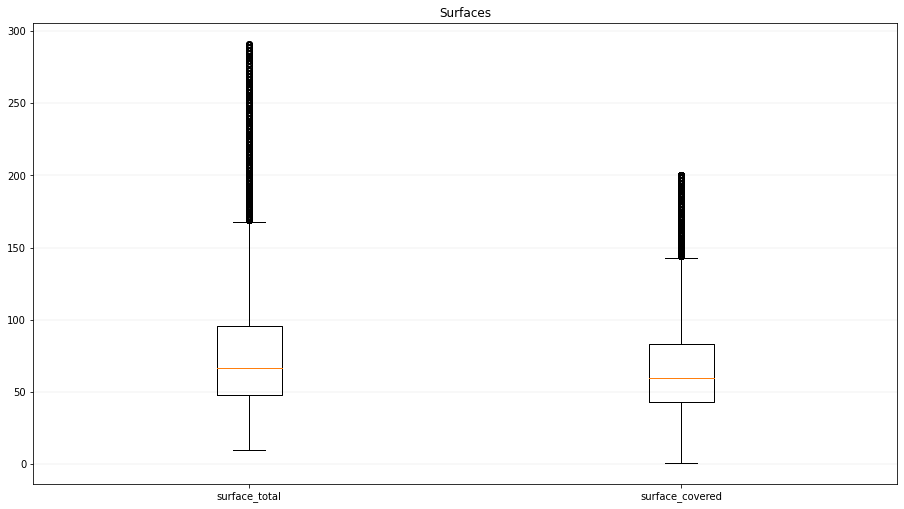

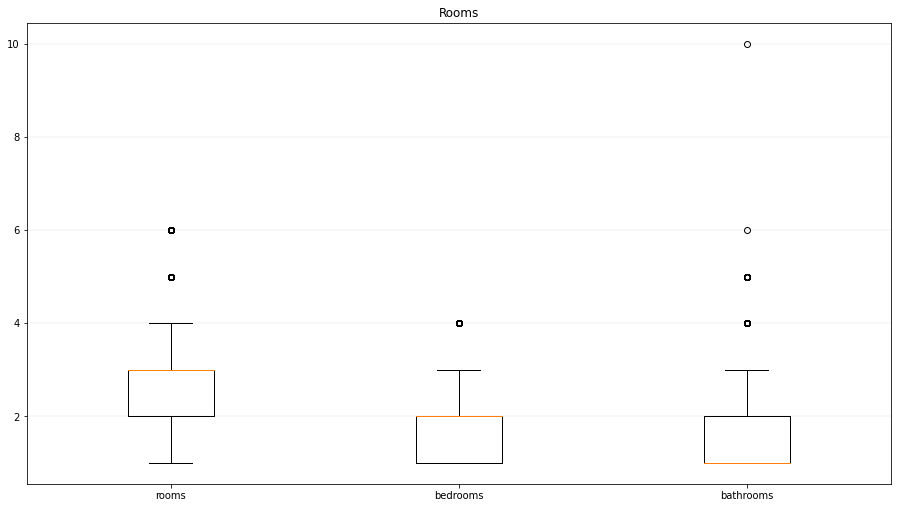

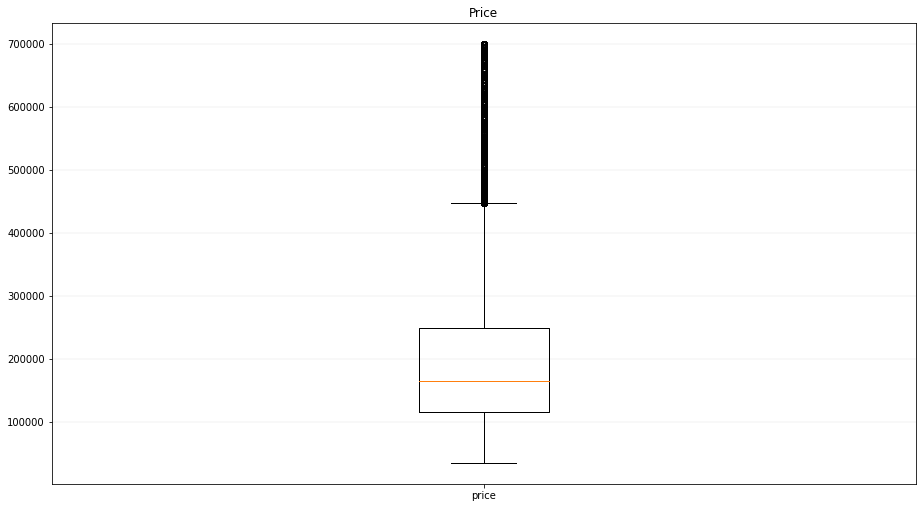


 Estadísticas : 


,Tipo Valor,Rango Valores,Promedio ± Desvío,¿Valores Ceros?,¿Valores Nulos?
neighborhood,object,{ Palermo 7413 ; Belgrano 5385 ; Almagro 4306 ; Villa Crespo 4227 ; Caballito 4209 ; ... ; Parque Chas 94 ; Villa Real 66 ; Villa Soldati 34 ; Catalinas 8 ; Villa Riachuelo 8 },-,0,0
rooms,float64,[ 1.00 ; 6.00 ],2.779 ± 1.024,0,0
bedrooms,float64,[ 1.00 ; 4.00 ],1.840 ± 0.856,0,0
bathrooms,float64,[ 1.00 ; 10.00 ],1.402 ± 0.645,0,0
surface_total,float64,[ 10.00 ; 291.00 ],78.209 ± 41.429,0,0
surface_covered,float64,[ 1.00 ; 200.00 ],68.351 ± 33.645,0,0
price,float64,[ 34300.00 ; 700000.00 ],199084.151 ± 121281.244,0,0
property_type,object,{ Departamento 53809 ; PH 6089 ; Casa 837 ; Oficina 308 },-,0,0


Tiene 8 atributos y 61043 ejemplos.




In [45]:
data_stat = data.copy()

x = data_stat.drop(['price', 'rooms', 'bedrooms', 'bathrooms'], axis=1)
plot_box_graph(x, 'Surfaces')

x = data_stat.drop(['price', 'surface_total', 'surface_covered'], axis=1)
plot_box_graph(x, 'Rooms')

x = data_stat.drop(['surface_total', 'surface_covered', 'rooms', 'bedrooms', 'bathrooms'], axis=1)
plot_box_graph(x, 'Price')

generar_estadisticas_detalladas(data, 'Estadísticas')

# Gráficos estadísticos

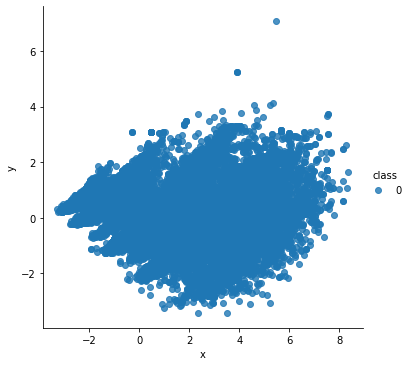

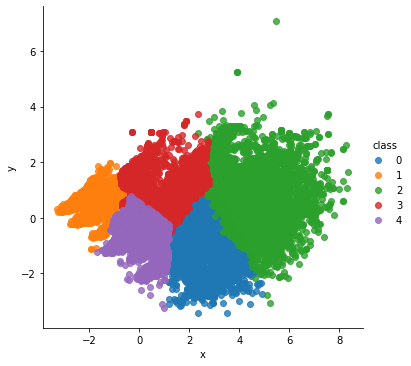

In [46]:
#@title Clusterizar con K-Means { run: "auto" }
#@markdown Cantidad de clústeres a generar:
cantidad_clusters =  5#@param {type:"integer"}

# Se clusteriza con datos numéricos
data_clust = only_numerics(data_norm)

# Como mínimo se tienen que generar dos clusters
if cantidad_clusters < 2:
    cantidad_clusters = 2

plot_pca(data_norm)
kmeans = KMeans(n_clusters=cantidad_clusters).fit(data_clust)
plot_pca(data_norm, classes=kmeans.labels_)

In [40]:
#@title Análisis de datos
data_stat = data.copy()
data_stat['class'] = kmeans.labels_

y_cols = list(data_stat.columns)
x_cols = list(data_stat.drop(columns=['neighborhood'], axis=1).columns)

y_data = np.array(data_stat)
x_data = np.array(data_stat.drop(columns=['neighborhood'], axis=1))

combo_x = widgets.Dropdown(
    options=x_cols,
    value=x_cols[0],
    description='Columna X:',
    disabled=False,
)

combo_y = widgets.Dropdown(
    options=y_cols,
    value=y_cols[1],
    description='Columna Y:',
    disabled=False,
)

ui = widgets.HBox([combo_x, combo_y])

def cambiaSeleccion(x, y):
    X = x_data[:, x_cols.index(x)]
    Y = y_data[:, y_cols.index(y)]

    if x == 'property_type':
        x_size = 3
    elif max(X) < 15:
        x_size = max(X) / 2
    else:
        x_size = 15

    if y == 'property_type':
        y_size = 3
    elif y == 'neighborhood':
        y_size = 20
    elif max(Y) < 15:
        y_size = max(Y) / 2
    else:
        y_size = 15

    plt.figure(figsize=(x_size, y_size))
    plt.scatter(X, Y, c=kmeans.labels_)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

out = widgets.interactive_output(cambiaSeleccion, {'x': combo_x, 'y': combo_y})
display(ui, out)

Output()

# DNN
https://towardsdatascience.com/training-neural-networks-for-price-prediction-with-tensorflow-8aafe0c55198

### Auxiliares

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [ ]:
# Funciones auxiliares
def performance_summary(model, X_test, y_test ):
    
    y_hat=model.predict(X_test)
    
    df_summary=pd.DataFrame(y_hat, columns=["y_hat"])
    df_summary["y_true"]=y_test
    df_summary["abs_error"]=np.abs(df_summary.y_true-df_summary.y_hat)
    df_summary["error"]=df_summary.y_hat-df_summary.y_true
    df_summary["relative_error"]= df_summary["error"]/df_summary.y_true
    df_summary["relative_abs_error"]= df_summary["abs_error"]/df_summary.y_true
    
    share_within_5pct=(df_summary.query("relative_abs_error<0.05").shape[0]/df_summary.shape[0])*100
    
    print("{:.2f}% : Share of forecasts within 5% absolute error\n".format(share_within_5pct))
    print("{:.0f}   : Mean absolute error \n".format(df_summary.abs_error.mean()))
    print("{:.2f}% : Mean absolute percentage error\n".format(df_summary.relative_abs_error.mean()*100))

def DNN_plot_loss(history, starting_epoch, previous_val_loss):

        trace0=go.Scatter(
                y=history.history['loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="blue",
                size=5,
                opacity=0.5
                ),
                name="Training Loss"
            )


        trace1=go.Scatter(
                y=history.history['val_loss'][starting_epoch:],
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="red",
                size=5,
                opacity=0.5
                ),
                name="Validation Loss"
            )
        
        trace2=go.Scatter(
                y=list(np.ones([len(history.epoch[starting_epoch:])])*np.asarray(previous_val_loss).min()),
                x=history.epoch[starting_epoch:],
                mode='lines',
                marker=dict(
                color="grey",
                size=5,

                ),
                name="Lowest error from previous models"
            )

        data=[trace0, trace1,trace2]
        figure=go.Figure(
            data=data,
            layout=go.Layout(
                title="Learning curve",
                yaxis=dict(title="Loss",range=(900,1500)),
                xaxis=dict(title="Epoch",range=(starting_epoch,history.epoch[-1])),
                legend=dict(
                    x=0.57,
                    y=1,
                    traceorder="normal",
                    font=dict(
                        family="sans-serif",
                        size=12,
                        color="black"
                    ),
                bgcolor=None,



            )))
        iplot(figure)

### Modelo

In [ ]:
# Libs
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint
from matplotlib.pyplot import figure
# from keras.utils.vis_utils import kplot_model
from tensorflow.keras.utils import plot_model


import keras

# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme

import plotly.figure_factory as ff
import plotly.graph_objects as go

# Se resetea el dataset
# La data ya se encuentra estandarizada y normalizada
data_dnn = data_norm

# Se arman los datos de entrenamiento
# Strings a números

def encode(df: pd.DataFrame):
    encoder = LabelEncoder()
    return encoder.fit_transform(df)

encodables = ['neighborhood', 'property_type']

for encodable in encodables:
    data_dnn[encodable] = encode(data_dnn[encodable])
    data_dnn[encodable] = scaler.fit_transform(data_dnn[encodable].values.reshape(-1, 1))    

ixs = data_dnn.index

x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(data_dnn, data_dnn.price, ixs, test_size=0.2, random_state=15)
data_dnn.head()

# Transformar de pd.DataFrame a arrays de numpy para meteren modelo de keras
x_train = np.asanyarray(x_train).astype('float32')
x_test = np.asanyarray(x_test).astype('float32')
y_train = np.asanyarray(y_train).astype('float32')
y_test = np.asanyarray(y_test).astype('float32')


,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
235,-0.267498,-0.760757,-0.980881,-0.623114,-0.415390,-0.218504,-0.729584,-0.309028
236,-1.332349,-0.760757,-0.980881,-0.623114,1.563913,2.218757,0.329121,-0.309028
237,0.012726,-0.760757,-0.980881,-0.623114,-0.922285,-1.021017,-0.907684,-0.309028
238,0.573174,-0.760757,-0.980881,-0.623114,-0.463666,-0.961572,-0.965402,2.929705
240,0.853398,-0.760757,-0.980881,-0.623114,-0.777458,-0.753513,-0.734531,-0.309028


In [ ]:
# Configuración

# copypaste
tf.keras.backend.clear_session()
tf.random.set_seed(60)

# Activación RELU para capas ocultas
# "Use RELU activation function for all hidden layers — you will be going nowhere with default sigmoid activation"
# Use Linear activation function for the single-neuron output layer
k = 1
# k = 64

model = Sequential([
    Dense(1024/k, input_dim = x_train.shape[1]),
    LeakyReLU(), # Función Activación (Modificación de RELU que permite activar valores negativos -> preveiene matar neuronas)
    BatchNormalization(), # Evita que neuronas muertas tengan efecto negativo en la RN
    Dropout(0.3), # Mata neuronas para evitar sobre entrenamiento

    Dense(1024/k),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512/k),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),

    Dense(256/k),
    LeakyReLU(),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(128/k),
    LeakyReLU(),
    Dropout(0.2),

    # Capa de salida
    Dense(1, activation='linear'),  # La salida es el precio (1 sólo valor)
], name="Modelo")

model.summary()

Model: "Modelo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              9216      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096 

In [ ]:
# Optimizador ??

# Loss: pérdida entre lo que se busca y lo que el modelo encuentra

optimizer = keras.optimizers.Adam(lr=0.005, decay=5e-4)  # Cuando tengamos todo lindo

model.compile(optimizer=optimizer, loss='mean_absolute_error')


def callbacks():
    checkpoint_name = 'Weights\Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
    checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
    callbacks_list = [checkpoint]

history = model.fit(x_train, y_train,
                    epochs=200, batch_size=1024,
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks(),
                    verbose=True)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



48/48 [==============================] - 17s 307ms/step - loss: 1.1241 - val_loss: 0.4486
Epoch 2/200
48/48 [==============================] - 14s 292ms/step - loss: 0.1613 - val_loss: 0.3320
Epoch 3/200
48/48 [==============================] - 14s 293ms/step - loss: 0.1152 - val_loss: 0.4303
Epoch 4/200
48/48 [==============================] - 14s 293ms/step - loss: 0.0952 - val_loss: 0.3198
Epoch 5/200
48/48 [==============================] - 14s 293ms/step - loss: 0.1103 - val_loss: 0.3423
Epoch 6/200
48/48 [==============================] - 14s 297ms/step - loss: 0.0861 - val_loss: 0.2903
Epoch 7/200
48/48 [==============================] - 14s 295ms/step - loss: 0.0847 - val_loss: 0.3043
Epoch 8/200
48/48 [==============================] - 14s 294ms/step - loss: 0.0976 - val_loss: 0.2000
Epoch 9/200
48/48 [==============================] - 14s 294ms/step - loss: 0.0855 - val_loss: 0.0722
Epoch 10/200
48/48 [==============================] - 14s 295ms/step - loss: 0.0862 - val_loss

<Figure size 1600x480 with 0 Axes>

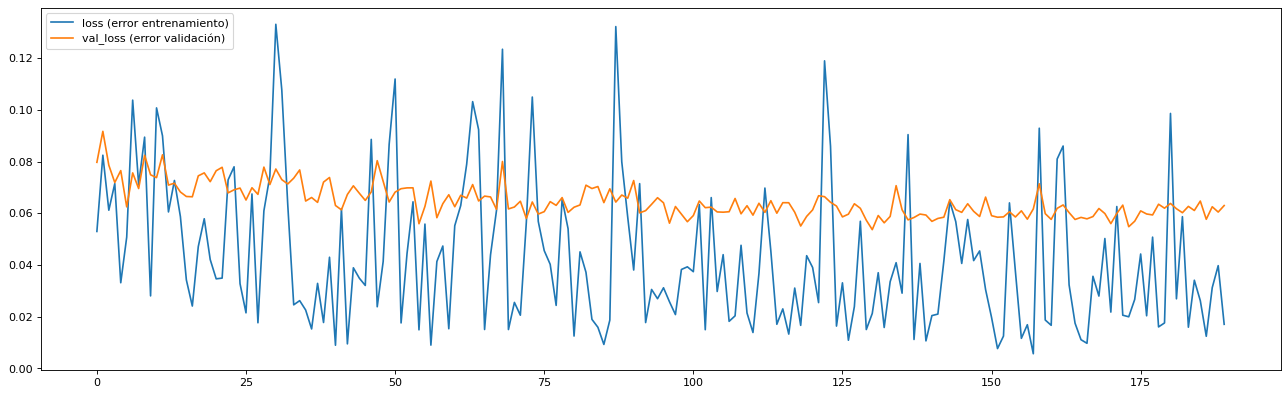

In [ ]:
figure(figsize=(20, 6), dpi=80)

plt.plot(history.history['val_loss'][10::])
plt.plot(history.history['loss'][10::])

plt.legend(['loss (error entrenamiento)', 'val_loss (error validación)'], loc='upper left')
plt.show()

In [ ]:
# data original, x entrada, y esperado, mapeo indices de x|y con data original, catndiad
def comparacion_resultados(data, x, y, ix, n, titulo=''):
    if titulo:
        print(f'\n{titulo}\n')

    # Agarro n nros al azar
    indexes = np.random.choice(len(ix), n)

    # x a predecir
    prueba = np.array([x[i] for i in indexes])

    # y esperado
    esperado = np.array([y[i] for i in indexes])

    # y predicto
    predicto = model.predict(prueba)

    # diferencia porcentual
    diff = [p[0] / esperado[i] for i, p in enumerate(predicto)]

    ## Recupero data real
    indexes_reales = [ix[i] for i in indexes]
    cmp_data = data.loc[indexes_reales]
    cmp_data['price_predicted'] = cmp_data['price'] * diff
    cmp_data['% difference'] = [f'{(1-p)*100:.2f}' for p in diff]
    return cmp_data

comparacion_resultados(data, x_train, y_train, i_train, 10, 'Precisión datos de entrenamiento')
comparacion_resultados(data, x_test, y_test, i_test, 10, 'Precisión datos de validación')


Precisión datos de entrenamiento



,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,price_predicted,% difference
753870,Barracas,4.0,3.0,2.0,155.0,110.0,330000.0,PH,333315.535784,-1.00
515113,San Cristobal,3.0,2.0,1.0,65.0,60.0,125000.0,Departamento,121336.333454,2.93
506224,Parque Centenario,4.0,3.0,3.0,118.0,118.0,255000.0,PH,259691.714644,-1.84
213839,Belgrano,3.0,2.0,2.0,80.0,80.0,308000.0,Departamento,311209.312439,-1.04
278165,Palermo Hollywood,1.0,1.0,1.0,45.0,45.0,100000.0,Departamento,96486.747265,3.51
304174,Belgrano,3.0,2.0,1.0,64.0,61.0,150000.0,Departamento,147798.818350,1.47
286640,Parque Chacabuco,2.0,1.0,1.0,55.0,40.0,139500.0,Departamento,137005.695283,1.79
555702,Villa Devoto,3.0,2.0,2.0,61.0,61.0,163700.0,Departamento,161078.374887,1.60
416647,Palermo,4.0,3.0,2.0,111.0,111.0,387000.0,Departamento,392329.491377,-1.38
778183,Caballito,2.0,1.0,1.0,41.0,39.0,95000.0,Departamento,91513.023376,3.67



Precisión datos de validación



,neighborhood,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type,price_predicted,% difference
698806,Boedo,3.0,2.0,1.0,91.0,61.0,160000.0,PH,156742.277145,2.04
299502,Almagro,3.0,2.0,1.0,66.0,66.0,159000.0,Departamento,157343.595207,1.04
597303,Barrio Norte,3.0,2.0,1.0,78.0,62.0,149000.0,Departamento,146723.758340,1.53
458275,Chacarita,4.0,3.0,1.0,95.0,95.0,171000.0,Departamento,174986.102700,-2.33
784909,San Telmo,1.0,1.0,1.0,33.0,32.0,74000.0,Departamento,71011.619687,4.04
292175,Almagro,1.0,1.0,1.0,36.0,33.0,79351.0,Departamento,76238.917212,3.92
3846,Palermo,3.0,2.0,1.0,79.0,79.0,278000.0,PH,276855.652928,0.41
306189,San Telmo,3.0,2.0,1.0,72.0,72.0,137000.0,Departamento,133807.149827,2.33
523839,Recoleta,2.0,1.0,1.0,74.0,74.0,225000.0,PH,221267.236769,1.66
490920,Palermo,3.0,2.0,2.0,76.0,73.0,310000.0,Departamento,313155.540228,-1.02


In [ ]:
comparacion_resultados(data, x_train, y_train, i_train, 10, 'Precisión datos de entrenamiento').transpose()



Precisión datos de entrenamiento



,39492,383282,514324,13611,166872,420315,814534,623216,69116,610111
neighborhood,Flores,Recoleta,Palermo,Villa Crespo,Parque Centenario,Belgrano,Villa Crespo,Flores,Villa Pueyrredón,Palermo Hollywood
rooms,4,2,1,2,4,3,3,2,2,2
bedrooms,2,1,1,1,3,2,2,1,1,1
bathrooms,3,1,1,1,2,2,1,1,1,1
surface_total,107,37,55,46,157,120,52,60,33,47
surface_covered,94,35,55,46,148,110,52,48,33,43
price,285000,120000,150000,119000,220000,385000,135000,92900,69900,185390
property_type,Departamento,Departamento,Departamento,Departamento,Departamento,Departamento,Departamento,Departamento,Departamento,Departamento
price_predicted,289919,116654,148783,115536,229670,389635,131786,89369.1,66999.7,194159
% difference,-1.73,2.79,0.81,2.91,-4.40,-1.20,2.38,3.80,4.15,-4.73
